# Pix2Pix: Image-to-Image Translation with Conditional Adversarial Networks

[Paper here](https://arxiv.org/pdf/1611.07004)

[Maps Dataset](https://www.kaggle.com/datasets/vikramtiwari/pix2pix-dataset/data?select=maps)


In [1]:
from rich import print
from tqdm.notebook import tqdm

%load_ext rich

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2
from torchvision.transforms import functional as TF
from torchvision.utils import make_grid
import random
# import wandb


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# wandb.require('core')
# wandb.login()

In [24]:
# Hyperparameters

GEN_FEATURE_MAP = 64
DISC_FEATURE_MAPS = [64, 128, 256, 512]

BATCH_SIZE = 64
N_EPOCHS = 50
LEARNING_RATE = 2e-4
L1_LAMBDA = 100

## Load the dataset

In [25]:
transform = v2.Compose(
    [
        v2.RandomResizedCrop(256, scale=(0.5, 1.0)),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [26]:
def reverse_transform(img):
    img = 0.5 * img + 0.5

    return v2.ToPILImage()(img)


In [27]:
class MapsDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.file_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.root_dir, self.file_list[index]))

        input, target = img.crop((0, 0, 600, 600)), img.crop((600, 0, 1200, 600))

        seed = random.randint(0, 2**32)

        random.seed(seed)
        torch.manual_seed(seed)
        input = transform(input)

        random.seed(seed)
        torch.manual_seed(seed)
        target = transform(target)

        return input, target


In [28]:
train_dataset = MapsDataset("./data/train")
val_dataset = MapsDataset("./data/val")

len(train_dataset), len(val_dataset)


(1096, 1098)

In [29]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


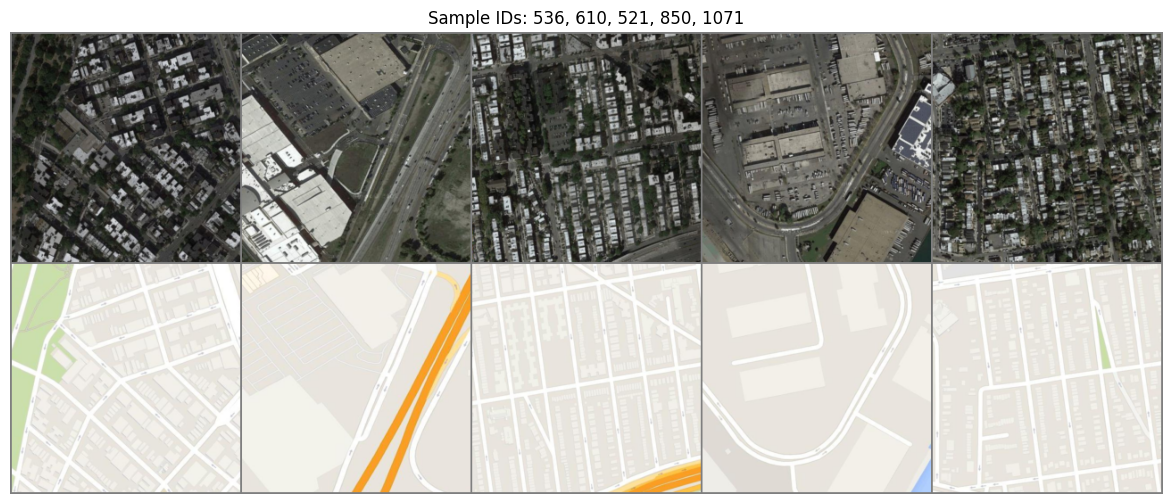

In [30]:
random_idxs = np.random.choice(range(len(train_dataset)), 5)

samples = [train_dataset[i] for i in random_idxs]

input_images = [s[0] for s in samples]
target_images = [s[1] for s in samples]

grid = make_grid(input_images + target_images, nrow=5)

plt.figure(figsize=(15, 6))
plt.imshow(reverse_transform(grid))
plt.title("Sample IDs: " + ", ".join(map(str, random_idxs)))
plt.axis("off")
plt.show()


In [31]:
print(input_images[0].shape, target_images[0].shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])

## Build the architecture

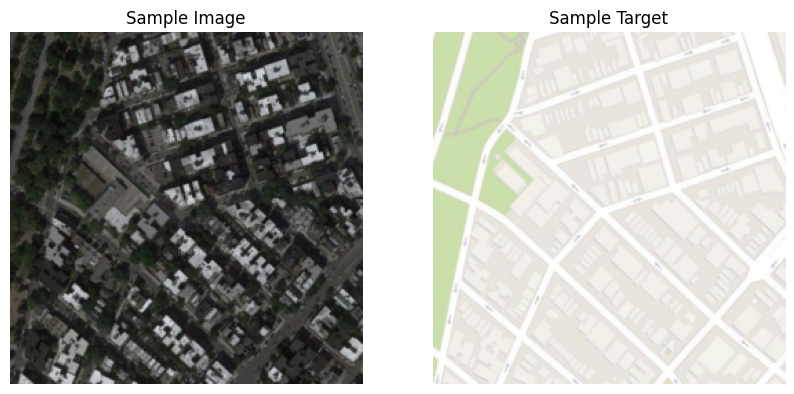

In [32]:
sample_image, sample_target = input_images[0], target_images[0]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(reverse_transform(sample_image))
plt.title("Sample Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(reverse_transform(sample_target))
plt.title("Sample Target")
plt.axis("off")

plt.show()

In [33]:
class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=4,
        padding=1,
        stride=2,
        normalize=True,
        down=True,
        activation="relu",
        dropout=False,
        debug=False,
    ):
        super(ConvBlock, self).__init__()

        self.normalize = normalize
        self.activation = activation
        self.dropout = dropout
        self.down = down

        self.activation_map = {
            "relu": nn.ReLU(),
            "leaky": nn.LeakyReLU(0.2),
            "tanh": nn.Tanh(),
            "sigmoid": nn.Sigmoid(),
        }

        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                padding_mode="reflect",
                bias=False,
            )
            if down
            else nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels) if normalize else nn.Identity(),
            nn.Dropout() if dropout else nn.Identity(),
            self.activation_map[activation],
        )

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            if self.down:
                print(f"[DOWNSAMPLE] {name}: {tensor.shape}")
            else:
                print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[CONV BLOCK] Input")
        x = self.block(x)
        self._debug_print(x, "[CONV BLOCK] Output")
        return x


In [14]:
ConvBlock(3, 64, stride=2, debug=True)(sample_image.unsqueeze(0))

[DOWNSAMPLE] [CONV BLOCK] Input: torch.Size([1, 3, 256, 256])

[DOWNSAMPLE] [CONV BLOCK] Output: torch.Size([1, 64, 128, 128])


tensor([[[[0.0000, 0.4544, 0.9454,  ..., 0.0000, 0.0000, 0.3384],
          [0.0000, 0.3087, 0.9922,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 1.1505,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3169, 0.3801, 0.6976],
          [0.0000, 0.0000, 0.0000,  ..., 0.2092, 0.2533, 0.5656],
          [0.0000, 0.0000, 0.0000,  ..., 0.3249, 0.4321, 0.9212]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1190, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.9571, 0.4660, 1.5850],
          [0.0000, 1.4397, 0.0102,  ..., 0.0000, 1.1793, 2.3628],
          ...,
          [0.1963, 0.9561, 0.3402,  ..., 0.0000, 0.0000, 0.0000],
          [0.0665, 0.3025, 0.1690,  ..., 0.0000, 0.0000, 0.0000],
          [0.0244, 0.0000, 0.0000,  ..., 0.0872, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.4653,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.1839,  ..., 1.7011, 0.0000, 0.0000],
          [0.0000, 0.4419, 0.0000,  ..., 

In [15]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, feature_maps, debug=False):
        super(Discriminator, self).__init__()

        self.feature_maps = feature_maps

        self.initial_conv = ConvBlock(
            in_channels * 2, feature_maps[0], stride=2, normalize=False
        )

        self.conv_layers = nn.Sequential(
            *[
                ConvBlock(
                    in_channels,
                    out_channels,
                    stride=1 if out_channels == feature_maps[-1] else 2,
                )
                for in_channels, out_channels in zip(
                    feature_maps[:-1], feature_maps[1:]
                )
            ]
        )

        self.final_conv = nn.Conv2d(
            in_channels=feature_maps[-1],
            out_channels=1,
            kernel_size=4,
            stride=1,
            padding=1,
            padding_mode="reflect",
        )

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        self._debug_print(x, "[DISCRIMINATOR] Input")
        x = self.initial_conv(x)
        self._debug_print(x, "[DISCRIMINATOR] Conv1")
        x = self.conv_layers(x)
        self._debug_print(x, f"[DISCRIMINATOR] {len(self.feature_maps)} Conv Layers")
        x = self.final_conv(x)
        self._debug_print(x, "[DISCRIMINATOR] Output")
        return x


In [16]:
d = Discriminator(3, [64, 128, 256, 512], debug=True)
d(sample_image.unsqueeze(0), sample_target.unsqueeze(0))


[DISCRIMINATOR] Input: torch.Size([1, 6, 256, 256])

[DISCRIMINATOR] Conv1: torch.Size([1, 64, 128, 128])

[DISCRIMINATOR] 4 Conv Layers: torch.Size([1, 512, 31, 31])

[DISCRIMINATOR] Output: torch.Size([1, 1, 30, 30])


tensor([[[[ 3.5553e-01,  1.4317e-02,  8.3608e-02, -2.6287e-01,  1.4957e-01,
            8.7468e-02,  1.4861e-01,  2.7545e-01,  6.2392e-01,  1.0815e-01,
           -1.2264e-01,  9.2019e-02, -3.2190e-01,  6.7439e-01,  7.8451e-01,
            1.0641e-01, -4.1746e-01, -2.8933e-01,  8.0293e-02, -2.4480e-01,
           -2.2432e-01, -8.7640e-02,  1.1676e-01, -1.6744e-01,  4.9561e-01,
           -2.7845e-01,  2.2536e-01,  5.9976e-01, -1.6964e-02,  3.9131e-03],
          [ 9.4495e-01,  5.7481e-01,  5.4681e-01,  2.6710e-01,  2.3444e-01,
            1.4362e-01,  1.0821e+00,  2.4796e-01,  9.3364e-02, -7.4799e-01,
           -4.4525e-01, -9.7789e-02,  5.3368e-02,  1.7926e-02, -3.8601e-01,
            3.5375e-02, -1.5306e-01,  5.3460e-01,  7.0351e-01,  6.1784e-01,
           -1.5425e-01,  6.1388e-01, -1.0310e-01,  5.2852e-01,  2.6962e-01,
            8.6966e-01,  2.2428e-01,  3.8485e-01,  5.5203e-01,  4.6070e-01],
          [ 5.9946e-02,  4.0036e-01,  3.8952e-02,  3.5900e-01,  2.5969e-01,
         

In [17]:
class Generator(nn.Module):
    def __init__(self, in_channels, feature_map, debug=False):
        super(Generator, self).__init__()

        self.encoder = nn.ModuleList(
            [
                ConvBlock(
                    in_channels, feature_map, normalize=False, activation="leaky"
                ),  # C64
                ConvBlock(feature_map, feature_map * 2, activation="leaky"),  # C128
                ConvBlock(feature_map * 2, feature_map * 4, activation="leaky"),  # C256
                ConvBlock(feature_map * 4, feature_map * 8, activation="leaky"),  # C512
                ConvBlock(feature_map * 8, feature_map * 8, activation="leaky"),  # C512
                ConvBlock(feature_map * 8, feature_map * 8, activation="leaky"),  # C512
                ConvBlock(feature_map * 8, feature_map * 8, activation="leaky"),  # C512
            ]
        )

        self.bottleneck = ConvBlock(
            feature_map * 8, feature_map * 8, normalize=False, activation="relu"
        )

        self.decoder = nn.ModuleList(
            [
                ConvBlock(
                    feature_map * 8,
                    feature_map * 8,
                    down=False,
                    activation="relu",
                    dropout=True,
                ),  # CD512
                ConvBlock(
                    feature_map * 8 * 2,
                    feature_map * 8,
                    down=False,
                    activation="relu",
                    dropout=True,
                ),  # CD512
                ConvBlock(
                    feature_map * 8 * 2,
                    feature_map * 8,
                    down=False,
                    activation="relu",
                    dropout=True,
                ),  # CD512
                ConvBlock(
                    feature_map * 8 * 2,
                    feature_map * 8,
                    down=False,
                    activation="relu",
                    dropout=True,
                ),  # CD512
                ConvBlock(
                    feature_map * 8 * 2,
                    feature_map * 4,
                    down=False,
                    activation="relu",
                ),  # C256
                ConvBlock(
                    feature_map * 4 * 2,
                    feature_map * 2,
                    down=False,
                    activation="relu",
                ),  # C128
                ConvBlock(
                    feature_map * 2 * 2,
                    feature_map,
                    down=False,
                    activation="relu",
                ),  # C64
            ]
        )

        self.final_conv = ConvBlock(
            feature_map * 2, in_channels, down=False, normalize=False, activation="tanh"
        )

        self.debug = debug

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x):
        self._debug_print(x, "[GENERATOR] Input")

        skips = []
        for ix, layer in enumerate(self.encoder):
            x = layer(x)
            self._debug_print(x, f"[GENERATOR] Encoder Layer {1 + ix}")
            skips.append(x)

        x = self.bottleneck(x)
        self._debug_print(x, "[GENERATOR] Bottleneck")

        x = self.decoder[0](x)
        self._debug_print(x, "[GENERATOR] Decoder Layer 0")

        skips = reversed(skips)
        for ix, layer in enumerate(self.decoder[1:]):
            skip = next(skips)
            self._debug_print(skip, f"[GENERATOR] Skip Layer {len(self.encoder)-ix}")
            x = layer(torch.cat([x, skip], dim=1))
            self._debug_print(x, f"[GENERATOR] Decoder Layer {1 + ix}")

        skip = next(skips)
        self._debug_print(skip, "[GENERATOR] Skip Layer 0")
        x = self.final_conv(torch.cat([x, skip], dim=1))

        self._debug_print(x, "[GENERATOR] Output")

        return x


[GENERATOR] Input: torch.Size([1, 3, 256, 256])

[GENERATOR] Encoder Layer 1: torch.Size([1, 64, 128, 128])

[GENERATOR] Encoder Layer 2: torch.Size([1, 128, 64, 64])

[GENERATOR] Encoder Layer 3: torch.Size([1, 256, 32, 32])

[GENERATOR] Encoder Layer 4: torch.Size([1, 512, 16, 16])

[GENERATOR] Encoder Layer 5: torch.Size([1, 512, 8, 8])

[GENERATOR] Encoder Layer 6: torch.Size([1, 512, 4, 4])

[GENERATOR] Encoder Layer 7: torch.Size([1, 512, 2, 2])

[GENERATOR] Bottleneck: torch.Size([1, 512, 1, 1])

[GENERATOR] Decoder Layer 0: torch.Size([1, 512, 2, 2])

[GENERATOR] Skip Layer 7: torch.Size([1, 512, 2, 2])

[GENERATOR] Decoder Layer 1: torch.Size([1, 512, 4, 4])

[GENERATOR] Skip Layer 6: torch.Size([1, 512, 4, 4])

[GENERATOR] Decoder Layer 2: torch.Size([1, 512, 8, 8])

[GENERATOR] Skip Layer 5: torch.Size([1, 512, 8, 8])

[GENERATOR] Decoder Layer 3: torch.Size([1, 512, 16, 16])

[GENERATOR] Skip Layer 4: torch.Size([1, 512, 16, 16])

[GENERATOR] Decoder Layer 4: torch.Size([1, 256, 32, 32])

[GENERATOR] Skip Layer 3: torch.Size([1, 256, 32, 32])

[GENERATOR] Decoder Layer 5: torch.Size([1, 128, 64, 64])

[GENERATOR] Skip Layer 2: torch.Size([1, 128, 64, 64])

[GENERATOR] Decoder Layer 6: torch.Size([1, 64, 128, 128])

[GENERATOR] Skip Layer 0: torch.Size([1, 64, 128, 128])

[GENERATOR] Output: torch.Size([1, 3, 256, 256])

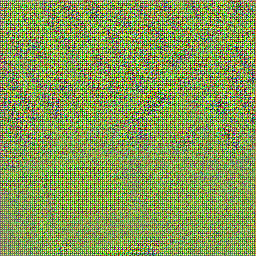

In [18]:
g = Generator(3, 64, debug=True)
reverse_transform(g(sample_image.unsqueeze(0)).squeeze(0))


In [34]:
g = Generator(in_channels=sample_image.shape[0], feature_map=GEN_FEATURE_MAP).to(device)
d = Discriminator(in_channels=sample_image.shape[0], feature_maps=DISC_FEATURE_MAPS).to(
    device
)

bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

g_optimizer = torch.optim.Adam(g.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(d.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

total_param_count = sum(p.numel() for p in g.parameters()) + sum(
    p.numel() for p in d.parameters()
)

print(f"Total number of parameters: { total_param_count / (1e6):.2f}M")

Total number of parameters: 57.18M

In [35]:
# wandb.init(
#     project="dcgan",
#     config={
#         "Generator Optimizer": g_optimizer.__class__.__name__,
#         "Discriminator Optimizer": d_optimizer.__class__.__name__,
#         "Loss Function": loss_fn.__class__.__name__,
#         "Batch Size": BATCH_SIZE,
#         "Epochs": N_EPOCHS,
#         "Learning Rate": LEARNING_RATE,
#         "Latent Dim": LATENT_DIM,
#         "Generator Feature Map Size": GEN_FEATURE_MAP,
#         "Discriminator Feature Map Size": DISC_FEATURE_MAP,
#         "Total Parameters": sum(p.numel() for p in g.parameters())
#         + sum(p.numel() for p in d.parameters()),
#     },
# )

In [36]:
g_losses = []
d_losses = []

for epoch in tqdm(range(N_EPOCHS), desc="Epochs"):
    # -------------------
    # Training loop
    # -------------------
    for idx, (imgs, targets) in enumerate(
        tqdm(train_loader, desc=f"Training Epoch {epoch}")
    ):
        batch_size = imgs.size(0)
        imgs, targets = imgs.to(device), targets.to(device)

        ## Train Discriminator
        d.train()
        d_optimizer.zero_grad()

        fake_imgs = g(imgs)

        d_real = d(imgs, targets)
        d_fake = d(imgs, fake_imgs.detach())

        d_real_loss = bce_loss(d_real, torch.ones_like(d_real))
        d_fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        d_optimizer.step()

        # -------------------------------
        ## Train Generator
        g.train()
        g_optimizer.zero_grad()

        d_fake = d(imgs, fake_imgs)

        g_fake_loss = bce_loss(d_fake, torch.ones_like(d_fake))
        g_l1_loss = l1_loss(fake_imgs, targets) * L1_LAMBDA
        g_loss = g_fake_loss + g_l1_loss

        g_loss.backward()
        g_optimizer.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # -------------------
    # Validation loop
    # -------------------

    val_image, val_target = next(iter(val_loader))
    val_image, val_target = val_image.to(device), val_target.to(device)

    g.eval()
    with torch.no_grad():
        val_fake = g(val_image)

    val_image = reverse_transform(val_image.squeeze(0))
    val_target = reverse_transform(val_target.squeeze(0))

    val_fake = reverse_transform(val_fake.squeeze(0))

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(val_image)
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    ax[1].imshow(val_target)
    ax[1].set_title("Target Image")
    ax[1].axis("off")

    ax[2].imshow(val_fake)
    ax[2].set_title("Generated Image")
    ax[2].axis("off")

    fig.suptitle(f"Epoch {epoch}")

    fig.savefig(f"./data/results/epoch_{epoch}.png")

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/18 [00:00<?, ?it/s]

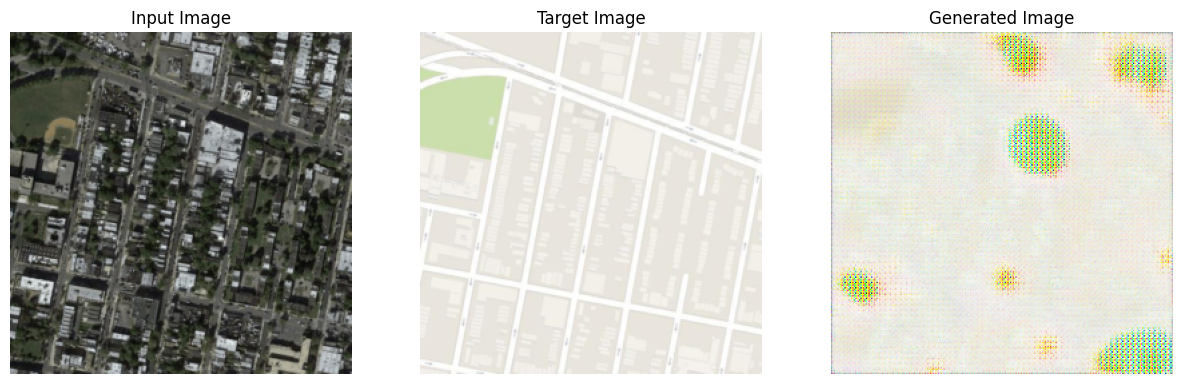

In [23]:
val_image, val_target = next(iter(val_loader))
val_image, val_target = val_image.to(device), val_target.to(device)

g.eval()
with torch.no_grad():
    val_fake = g(val_image)

val_image = reverse_transform(val_image.squeeze(0))
val_target = reverse_transform(val_target.squeeze(0))

val_fake = reverse_transform(val_fake.squeeze(0))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(val_image)
ax[0].set_title("Input Image")
ax[0].axis("off")

ax[1].imshow(val_target)
ax[1].set_title("Target Image")
ax[1].axis("off")

ax[2].imshow(val_fake)
ax[2].set_title("Generated Image")
ax[2].axis("off")

plt.show()
